In [1]:
import pandas as pd #lectura de datos
import numpy as np # biblioteca con operaciones matemáticas y algebra lineal
import mysql.connector # importar la base de datos


#viz y plots bonitos
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('ggplot')
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams[u'figure.figsize'] = (16,12)
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large'}
plt.rcParams.update(params)

# preprocesamiento de datos
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

#tuneo de metaparametros
from sklearn.model_selection import GridSearchCV

# Modelos
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier

# metricas de evaluacion
from sklearn.metrics import (roc_auc_score, classification_report, confusion_matrix,
                            roc_curve, accuracy_score)
# lo mismo pero en grafico
import scikitplot as skplt

# Interpretacion
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import shap

In [85]:
cnx = mysql.connector.connect(
        user='ligamx_scrapper', 
        password='1234qwer', # note apures... nunca uso esa contrasenia :v
        host='localhost',
        database='ligamx')

In [86]:
df = pd.read_sql_query("SELECT * FROM ligamx.match;", con=cnx)
df["match_date"] = pd.to_datetime(df.match_date)

# df.head()

In [87]:
# Variable si depende del mes y dia que juegan
df["match_year"] = df.match_date.dt.year
df["match_month"] = df.match_date.dt.month
dict_day = {0:'Lunes',1:'Martes',2:'Miercoles',3:'Jueves',4:'Viernes',5:'Sabado',6:'Domingo'}
df["match_diasemana"] = df.match_date.dt.weekday.map(dict_day)
# Checamos que los nombres no esten repetidos
team_dict = {'Gallos Blancos':'Club Querétaro','Laguna':'Santos'}
df.home_team = df.home_team.apply(lambda x: team_dict.get(x,x))
df.away_team = df.away_team.apply(lambda x: team_dict.get(x,x))
# Guardamos el resultado que sera nuestra variable a predecir al hacerlo multiclase
df['resultado'] = np.where(df.home_score > df.away_score, 'local',
                          np.where(df.home_score == df.away_score, 'empate',
                                  'visitante'))

In [88]:
df['ganador'] = np.where(df.home_score > df.away_score, df.home_team,
                          np.where(df.home_score == df.away_score, 'empate',
                                  df.away_team))

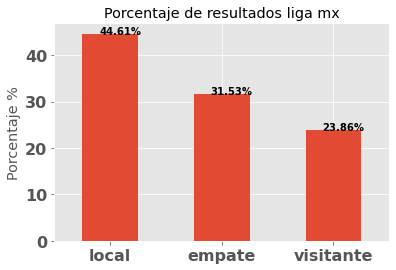

In [89]:
res = df.resultado.value_counts(normalize=True) * 100
res.plot.bar(rot=0, title='Porcentaje de resultados liga mx')
plt.ylabel('Porcentaje %')
for ind,i in enumerate(res.values):
    plt.text(ind-0.1,i,str(round(i,2))+'%')

# Solo por hobbie hagamos una carrera de barras

In [175]:
import bar_chart_race as bcr
# necesario instalar ffmepg, hit utiliza conda...! funciona

In [299]:
# creamos un par de columnas para mejorar la visualizacion
df['year_month'] = pd.to_datetime(df.match_date).dt.to_period('m')
df['es_liguilla'] = np.where(df.match_name.str[:7] != 'Jornada',1,0)

In [300]:
df_bar_race = df[df['es_liguilla'] != 1]
df_bar_race = df.groupby("year_month").ganador.value_counts().unstack(1)
df_bar_race = df_bar_race.reset_index().set_index("year_month").fillna(0).cumsum()
df_bar_race.index = df_bar_race.index.to_timestamp()
df_bar_race.drop(['empate','Ángeles','Atlético Español','Campesinos','Cobras','Correcaminos',
                 'Cuernavaca','Indios','La Piedad','Tampico Madero','Atlético de San Luis'],axis=1,inplace=True)

In [301]:
def period_summary(values, ranks):
    top2 = values.nlargest(2)
    leader = top2.index[0]
    lead = top2.iloc[0] - top2.iloc[1]
    s = f'{leader} by {lead:.0f}'
    return {'s': s, 'x': .95, 'y': .07, 'ha': 'right', 'size': 8}

bcr.bar_chart_race(df=df_bar_race, 
                   filename= None, #'ligamx_winners.mp4', 
                   n_bars=10, 
                   period_fmt = ' %B %Y', 
                   title='Partidos ganados acumulados de la Liga MX 1975-2019 sin liguillas',
                   bar_label_size=7,
                   tick_label_size=8,
                   steps_per_period=6,
                   bar_kwargs={'alpha': .7},
                   period_summary_func=period_summary,
                   perpendicular_bar_func='median',
                   scale='linear',
                   cmap=['yellow','blue','gold','red','navy','red','aqua',
                   'brown','red','snow','greenyellow','aqua','orangered',
                   'deepskyblue','limegreen','lightcoral','b','darkred','navy','white',
                   'chocolate','lawngreen','darksalmon','silver','gray','navy','lightgreen','firebrick',
                   'royalblue','w','cornflowerblue','dodgerblue','olive','palegreen'
                   ,'yellow','r','crimson','chartreuse','seashell'],
                   filter_column_colors=False)

In [47]:
df.groupby('tournament_name').size()

tournament_name
apertura 2002    204
apertura 2003    208
apertura 2004    167
apertura 2005    158
apertura 2006    169
                ... 
verano 1997      169
verano 1998      171
verano 1999      169
verano 2001      162
verano 2002      189
Length: 65, dtype: int64